# Fraud Detection Project (Estratégia - CRISP-DM)

## 1. Entendimento do Negócio

Com o aumento das transações eletrônicas em pontos de venda físicos, o uso de cartões de crédito tornou-se essencial no cotidiano. No entanto, essa facilidade também trouxe um aumento nas fraudes, incluindo transações fraudulentas em terminais físicos comprometidos e ataques direcionados a esses locais.
Fraudes em terminais físicos prejudicam financeiramente as instituições e afetam a confiança dos consumidores, além de impactar negativamente a reputação das empresas envolvidas. Por isso, enfretamos uma demanda crescente por soluções automatizadas que possam examinar rapidamente grandes volumes de transações e identificar padrões de fraude em terminais físicos.

**Objetivo**: 
Neste Case, o objetivo é desenvolver um modelo de machine learning para detecção de fraudes em cartões de crédito, focado exclusivamente em transações realizadas em terminais físicos.

Como não há um modelo prévio de detecção de fraude, todas as fraudes são contabilizadas como perdas. Assim, o baseline inicial será definido como:

$\text{total perdido}$ = $\text{total fraud}$

sendo: 
- $\text{total fraud}$ = soma de todos os valores das transações consideradas fraude no periodo avaliado

## 2. Entendimento dos Dados

**Objetivo**: Nosso conjunto de dados foi obtido a partir do livro: 
- https://fraud-detection-handbook.github.io/fraud-detection-handbook/Chapter_3_GettingStarted/SimulatedDataset.html

Nosso conjunto de dados é composto por duas tabelas:
1. transactions
    - **transaction_id**: Identificador único das transações;

    - **tx_datetime**: Date e hora que a transação ocorreu;

    - **customer_id**: Identificador único do cliente. Cada cliente tem um identificador único;

    - **tx_amount**: Valor da transação;

    - **tx_time_seconds**: Datetime em segundos
    
    - **tx_fraud**: Variável binária, com o valor 0 para transações legitmas e 1 para transações fraudulentas.


2. Customer
    - **customer_id**: The customer unique ID

    - **(x_customer_id,y_customer_id)**: Par de coordenadas reais em uma grade 100*100 que define a localização geográfica do cliente.
    
    - **mean_amount / std_amount**: A média e o desvio padrão dos valores de transação dos clientes.

## 3. Preparação dos Dados

**Objetivo**: Criar features robustas e eliminar informações desnecessárias.
    
- Ciclo 01:
    - Manter as variáveis originais

- Ciclo 02:
    - Criar um book de features

- Ciclo 03:
    - Seleciona as principais features

## 4. Modelagem

**Objetivo**: Construir modelos preditivos e avaliar performance.
    
- Ciclo 01:
    - Criar Random Forest, XGBoost e LightGBM com todas as features para obter um novo baseline.
    - Calcular AUC-ROC, Recall, Precision, F1-Score.
    - Avaliar o total perdido

- Ciclo 02:
    - Criar a RF, XGBoost e LightGBM com todas as features do book de features
    - Calcular AUC-ROC, Recall, Precision, F1-Score.
    - Avaliar o total perdido
    - Fazer um feature importance e encontrar as melhores variáveis

- Ciclo 03:
    - Criar a XGBoost e LightGBM com as melhores features
    - Fazer Cross-Validation e Tunagem dos hiper parâmetros para encontrar os melhores hiperparâmetros.
    - Calcular AUC-ROC, Recall, Precision, F1-Score.
    - Avaliar o total perdido

## 5. Avaliação

**Objetivo**: Verificar se o modelo atende às necessidades de detecção de fraudes.

- Construir um novo $\text{total perdido}$ baseado na matriz de confusão.

- Métricas principais: 
    - Matriz de Confusão
    - AUC-ROC, 
    - Recall, 
    - Precision, 
    - F1-Score

## 6. Deploy (Produção)

Em breve

# Fraud Detection Project (Código)

## Imports

In [1]:
import time
import math
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit, cross_val_predict
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

import optuna
import pickle

C:\Users\caiom\.conda\envs\fraud_detection\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Lendo arquivos CSV

In [2]:
main_dir = '../'

transactions_df = pd.read_csv(f'{main_dir}data/csv_raw_files/new_transactions.csv')
customer_profiles_table = pd.read_csv(f'{main_dir}data/csv_raw_files/new_customer_profiles_table.csv')
terminal_profiles_table = pd.read_csv(f'{main_dir}data/csv_raw_files/new_terminal_profiles_table.csv')

## Checando Tipos

In [3]:
transactions_df.dtypes

transaction_id       int64
tx_datetime         object
customer_id          int64
terminal_id          int64
tx_amount          float64
tx_time_seconds      int64
tx_time_days         int64
tx_fraud             int64
dtype: object

In [4]:
customer_profiles_table.dtypes

customer_id             int64
x_customer_id         float64
y_customer_id         float64
mean_amount           float64
std_amount            float64
mean_nb_tx_per_day    float64
dtype: object

In [5]:
terminal_profiles_table.dtypes

terminal_id        int64
x_terminal_id    float64
y_terminal_id    float64
dtype: object

# Limpando dados

Removido as colunas de media e std para evitar dataleakage

In [6]:
customer_profiles_table = customer_profiles_table.drop(columns=["std_amount","mean_amount"])

Convertido data da transação para datetime

In [7]:
transactions_df['tx_datetime'] = pd.to_datetime(transactions_df['tx_datetime']) 

# Separação em Treino e Teste

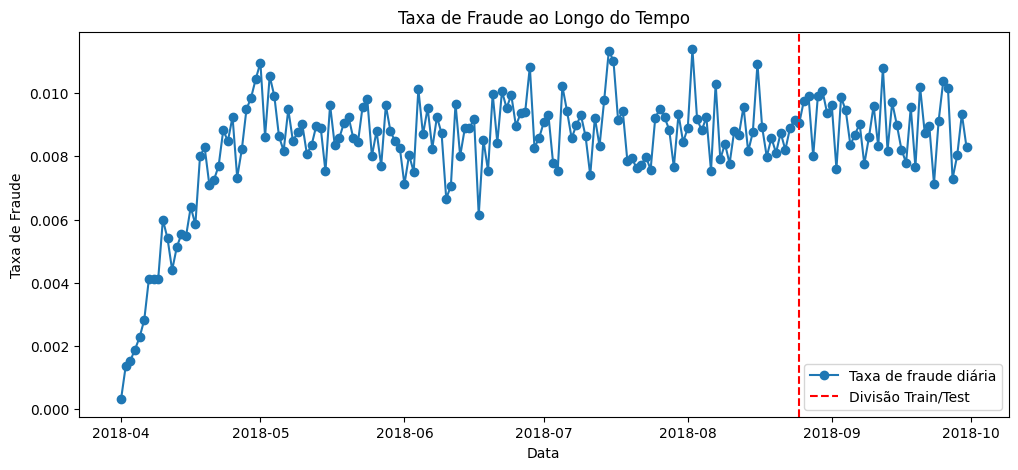

In [8]:
transactions_df["tx_date"] = transactions_df["tx_datetime"].dt.date
fraude_por_dia = transactions_df.groupby("tx_date")["tx_fraud"].mean()
split_date = transactions_df["tx_datetime"].quantile(0.8)

plt.figure(figsize=(12, 5))
plt.plot(fraude_por_dia, marker="o", linestyle="-", label="Taxa de fraude diária")
plt.axvline(split_date.date(), color="red", linestyle="--", label="Divisão Train/Test")
plt.xlabel("Data")
plt.ylabel("Taxa de Fraude")
plt.title("Taxa de Fraude ao Longo do Tempo")
plt.legend()
plt.show()

A divisão em 80% faz sentido, a variação de fraudes diárias não muda muito do padrão visto anteriormente.

In [9]:
transactions_df = transactions_df.sort_values(by="tx_datetime")

split_date = transactions_df["tx_datetime"].quantile(0.8)

train_df = transactions_df[transactions_df["tx_datetime"] < split_date]
test_df = transactions_df[transactions_df["tx_datetime"] >= split_date]

In [10]:
df_merged = pd.merge(train_df,customer_profiles_table, on='customer_id', how='left')
df_train_merged = pd.merge(df_merged, terminal_profiles_table, on='terminal_id', how='left')

df_merged = pd.merge(test_df,customer_profiles_table, on='customer_id',how='left')
df_test_merged = pd.merge(df_merged, terminal_profiles_table, on='terminal_id', how='left')

# EDA

In [11]:
train_df = df_train_merged.copy()
test_df = df_test_merged.copy()

C:\Users\caiom\AppData\Local\Temp\ipykernel_27824\2519046426.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_df, x="tx_fraud", y="tx_amount", showfliers=False, palette="coolwarm")


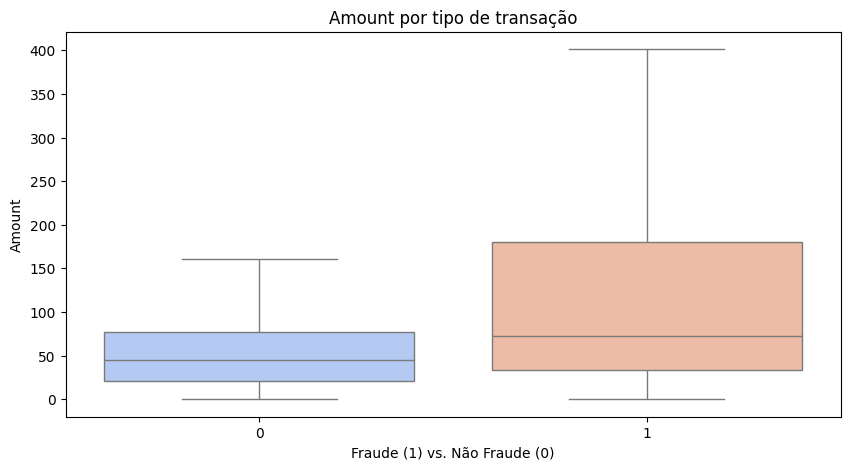

In [12]:
# Analisar tempo entre transações normais vs fraudes
plt.figure(figsize=(10, 5))
sns.boxplot(data=train_df, x="tx_fraud", y="tx_amount", showfliers=False, palette="coolwarm")
plt.title("Amount por tipo de transação")
plt.xlabel("Fraude (1) vs. Não Fraude (0)")
plt.ylabel("Amount")
plt.show()

In [13]:
train_df.groupby("tx_fraud")[["tx_amount"]].mean()

,tx_amount
tx_fraud,
0,52.986005
1,131.298758


O boxplot e a média das transações indica que transações maiores tem chance de serem fraudulentas

C:\Users\caiom\AppData\Local\Temp\ipykernel_27824\2339579971.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_df, x="tx_fraud", y="tx_time_seconds", showfliers=False, palette="coolwarm")


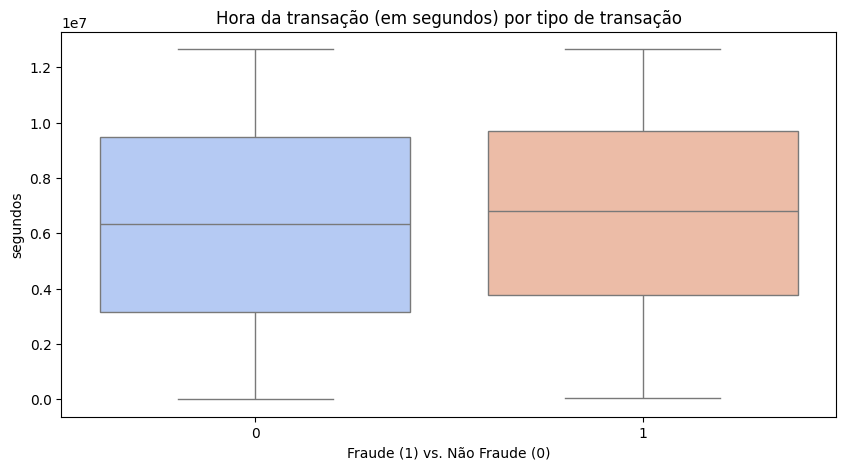

In [14]:
# Analisar tempo entre transações normais vs fraudes
plt.figure(figsize=(10, 5))
sns.boxplot(data=train_df, x="tx_fraud", y="tx_time_seconds", showfliers=False, palette="coolwarm")
plt.title("Hora da transação (em segundos) por tipo de transação")
plt.xlabel("Fraude (1) vs. Não Fraude (0)")
plt.ylabel("segundos")
plt.show()

Não deu pra ver diferenças.

## Feature Engineering

In [15]:
def feature_engineering(df):
    import time
    start_time = time.time()

    def time_features(df):
        # Ordenar os dados por cliente e data para cálculo de diferenças de tempo
        df = df.sort_values(by=["customer_id", "tx_datetime"])
    
        # Criar feature de tempo desde a última transação do cliente
        df["time_since_last_tx"] = df.groupby("customer_id")["tx_datetime"].diff().dt.total_seconds()
        
        df["tx_hour"] = df["tx_datetime"].dt.hour
        df["weekday_of_day"] = df["tx_datetime"].dt.weekday
        df['month'] = df['tx_datetime'].dt.month
        df['year'] = df['tx_datetime'].dt.year
        df['is_weekend'] = df['tx_datetime'].dt.dayofweek >= 5
        df['month_reference'] = df['tx_datetime'].dt.strftime('%Y%m')

        df["tx_day"] = df["tx_datetime"].dt.day
        df["tx_month"] = df["tx_datetime"].dt.month
        
        # categoria por horario do dia
        df["tx_period_day"] = pd.cut(
            df["tx_hour"],
            bins=[0, 6, 12, 18, 24],
            labels=["madrugada", "manhã", "tarde", "noite"],
            right=False,
        )
        
        return df

    def haversine(lon1,lat1,lon2,lat2):
        # convertes de graus para radianos
        lat1_rad = math.radians(lat1)
        lon1_rad = math.radians(lon1)
        lat2_rad = math.radians(lat2)
        lon2_rad = math.radians(lon2)

        delta_lat = lat2_rad - lat1_rad
        delta_lon = lon2_rad - lon1_rad

        # formula de haversine
        a = math.sin(delta_lat/2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(delta_lon / 2) ** 2
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))

        raio_terra = 6371.0

        distancia = raio_terra * c
        return distancia

    def add_geodistance(df):
        df['distance_customer_terminal'] = df.apply(
            lambda row: haversine(row['x_customer_id'], row['y_customer_id'], row['x_terminal_id'], row['y_terminal_id']),
            axis=1
        )
        return df

    def add_behavioral_flags(df):
        """Cria flags binárias de comportamento atípico ou padrão."""
        df["is_single_tx_customer"] = df.groupby("customer_id")["transaction_id"].transform("count") == 1
        df["repeated_tx"] = df.duplicated(subset=["customer_id", "tx_amount"], keep=False)
        df["outlier_tx"] = np.abs(df["tx_amount"] - df["mean_amount"]) > (2 * df["std_amount"])
        df["high_value_tx"] = df["tx_amount"] > (3 * df["mean_amount"])
        df["unusual_hour"] = (df["tx_hour"] < 6) | (df["tx_hour"] > 22)
        df["frequent_tx"] = df["time_since_last_tx"] < 60  # em segundos?
        df['consecutive_transactions_same_terminal'] = df['terminal_id'] == df.groupby('customer_id')['terminal_id'].shift(1)
        return df

    def aggregate_features(df):
        df = df.sort_values(by=["customer_id", "tx_datetime"])
        window_sizes = ['1h', '2h', '4h', '8h', '12h', '24h']
        
        results = []
        for cust_id, group in df.groupby("customer_id"):
            group = group.sort_values("tx_datetime").copy()
            group.set_index("tx_datetime", inplace=True)
    
            for window in window_sizes:
                # Todas as métricas de uma vez
                rolled = (
                    group[["tx_amount"]]
                    .rolling(window=window, min_periods=1)
                    .agg({
                        "tx_amount": ["count", "sum", "mean", "std", "median", "max"]
                    })
                )
    
                # Corrige nome das colunas multiindex
                rolled.columns = [f"{stat}_amount_per_customer_last_{window}" for stat in ["count", "total", "mean", "std", "median", "max"]]
    
                group = pd.concat([group, rolled], axis=1)
    
                # z-score
                group[f'std_amount_per_customer_last_{window}'] = group[f'std_amount_per_customer_last_{window}'].replace(0, 1e-6)
                group[f'amount_zscore_per_customer_last_{window}'] = (
                    (group["tx_amount"] - group[f'mean_amount_per_customer_last_{window}']) / group[f'std_amount_per_customer_last_{window}']
                )
    
            group.reset_index(inplace=True)
            results.append(group)
    
        df = pd.concat(results, ignore_index=True)
    
        # Calcular os ratios entre janelas (fora do loop por cliente para evitar recalcular a cada grupo)
        for window in window_sizes[1:]:  # começa do segundo item (p/ comparar com 1h)
            df[f'ratio_mean_amount_per_customer_last_1h_to_{window}'] = (
                df['mean_amount_per_customer_last_1h'] / df[f'mean_amount_per_customer_last_{window}']
            )
            df[f'ratio_total_transactions_per_customer_last_1h_to_{window}'] = (
                df['count_amount_per_customer_last_1h'] / df[f'count_amount_per_customer_last_{window}']
            )

        return df
    
    def add_value_statistics(df):
        """Cria estatísticas por cliente e razões com o valor atual."""
        df["mean_amount"] = df.groupby("customer_id")["tx_amount"].transform("mean")
        df["std_amount"] = df.groupby("customer_id")["tx_amount"].transform("std")
        df["tx_amount_median_ratio"] = df["tx_amount"] / df.groupby("customer_id")["tx_amount"].transform("median")
        df["tx_amount_to_mean_ration"] = df["tx_amount"] / df["mean_amount"]
        return df

    def add_hourly_patterns(df):
        """Adiciona padrões por hora do dia para cada cliente."""
        df["nb_tx_hour"] = df.groupby(["customer_id", "tx_hour"])["tx_amount"].transform("count")
        df["tx_amount_hour_mean"] = df.groupby(["customer_id", "tx_hour"])["tx_amount"].transform("mean")
        return df

    def add_time_between_txs_stats(df):
        """Adiciona estatísticas do tempo entre transações (assume que time_since_last_tx já foi criado)."""
        df["mean_time_between_txs"] = df.groupby("customer_id")["time_since_last_tx"].transform("mean")
        df["std_time_between_txs"] = df.groupby("customer_id")["time_since_last_tx"].transform("std")
        return df

    def add_tx_variation(df):
        """Adiciona a variação percentual de valor das transações."""
        df["tx_amount_variation"] = df.groupby("customer_id")["tx_amount"].transform(lambda x: x.pct_change().fillna(0))
        return df

    df = add_geodistance(df)
    df = aggregate_features(df)
    df = time_features(df)
    df = add_value_statistics(df)
    df = add_hourly_patterns(df)
    df = add_time_between_txs_stats(df)
    df = add_tx_variation(df)
    df = add_behavioral_flags(df)

    end_time = time.time()
    print(f"Tempo de execução: {end_time - start_time:.2f} segundos")
    return df

In [16]:
def feature_engineering_test(train_df, test_df):
    def time_features(train_df):
        # Ordenar os dados por cliente e data para cálculo de diferenças de tempo
        train_df = train_df.sort_values(by=["customer_id", "tx_datetime"])
    
        # Criar feature de tempo desde a última transação do cliente
        train_df["time_since_last_tx"] = train_df.groupby("customer_id")["tx_datetime"].diff().dt.total_seconds()
        
        train_df["tx_hour"] = train_df["tx_datetime"].dt.hour
        train_df["weekday_of_day"] = train_df["tx_datetime"].dt.weekday
        train_df['month'] = train_df['tx_datetime'].dt.month
        train_df['year'] = train_df['tx_datetime'].dt.year
        train_df['is_weekend'] = train_df['tx_datetime'].dt.dayofweek >= 5
        train_df['month_reference'] = train_df['tx_datetime'].dt.strftime('%Y%m')
    
        train_df["tx_day"] = train_df["tx_datetime"].dt.day
        train_df["tx_month"] = train_df["tx_datetime"].dt.month
        
        # categoria por horario do dia
        train_df["tx_period_day"] = pd.cut(
            train_df["tx_hour"],
            bins=[0, 6, 12, 18, 24],
            labels=["madrugada", "manhã", "tarde", "noite"],
            right=False,
        )
        
        return train_df
    
    def haversine(lon1,lat1,lon2,lat2):
        # convertes de graus para radianos
        lat1_rad = math.radians(lat1)
        lon1_rad = math.radians(lon1)
        lat2_rad = math.radians(lat2)
        lon2_rad = math.radians(lon2)
    
        delta_lat = lat2_rad - lat1_rad
        delta_lon = lon2_rad - lon1_rad
    
        # formula de haversine
        a = math.sin(delta_lat/2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(delta_lon / 2) ** 2
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    
        raio_terra = 6371.0
    
        distancia = raio_terra * c
        return distancia
    
    def add_geodistance(train_df):
        train_df['distance_customer_terminal'] = train_df.apply(
            lambda row: haversine(row['x_customer_id'], row['y_customer_id'], row['x_terminal_id'], row['y_terminal_id']),
            axis=1
        )
        return train_df
        
    def add_tx_variation(train_df):
        """Adiciona a variação percentual de valor das transações."""
        train_df["tx_amount_variation"] = train_df.groupby("customer_id")["tx_amount"].transform(lambda x: x.pct_change().fillna(0))
        return train_df

    def compute_reference_stats(train_df):
        reference_stats = {}
        reference_stats["mean_amount_per_customer"] = train_df.groupby("customer_id")["tx_amount"].mean()
        reference_stats["std_amount_per_customer"] = train_df.groupby("customer_id")["tx_amount"].std().replace(0, 1e-6)
        reference_stats["median_amount_per_customer"] = train_df.groupby("customer_id")["tx_amount"].median()
        train_df["tx_hour"] = train_df["tx_datetime"].dt.hour
        ref_hour_group = train_df.groupby(["customer_id", "tx_hour"])["tx_amount"]
        reference_stats["count_tx_per_hour"] = ref_hour_group.count()
        reference_stats["mean_tx_amount_per_hour"] = ref_hour_group.mean()
        train_df = train_df.sort_values(by=["customer_id", "tx_datetime"])
        train_df["time_since_last_tx"] = train_df.groupby("customer_id")["tx_datetime"].diff().dt.total_seconds()
        reference_stats["mean_time_between_txs"] = train_df.groupby("customer_id")["time_since_last_tx"].mean()
        reference_stats["std_time_between_txs"] = train_df.groupby("customer_id")["time_since_last_tx"].std().replace(0, 1e-6)
        return reference_stats

    def apply_reference_stats(train_df, reference_stats):
        train_df = train_df.copy()
    
        if "tx_hour" not in train_df.columns:
            train_df["tx_hour"] = train_df["tx_datetime"].dt.hour
    
        # Mapear estatísticas por cliente
        train_df["mean_amount"] = train_df["customer_id"].map(reference_stats["mean_amount_per_customer"])
        train_df["std_amount"] = train_df["customer_id"].map(reference_stats["std_amount_per_customer"])
        train_df["median_amount"] = train_df["customer_id"].map(reference_stats["median_amount_per_customer"])
    
        # Features derivadas
        train_df["tx_amount_to_mean_ration"] = train_df["tx_amount"] / train_df["mean_amount"]
        train_df["tx_amount_median_ratio"] = train_df["tx_amount"] / train_df["median_amount"]
        train_df["outlier_tx"] = np.abs(train_df["tx_amount"] - train_df["mean_amount"]) > (2 * train_df["std_amount"])
        train_df["high_value_tx"] = train_df["tx_amount"] > (3 * train_df["mean_amount"])
        train_df = train_df.drop(columns=['median_amount'],axis=1)
        # Padrões por hora
        train_df["nb_tx_hour"] = train_df.set_index(["customer_id", "tx_hour"]).index.map(reference_stats["count_tx_per_hour"])
        train_df["tx_amount_hour_mean"] = train_df.set_index(["customer_id", "tx_hour"]).index.map(reference_stats["mean_tx_amount_per_hour"])
    
        # Mapear tempos médios e std
        train_df["mean_time_between_txs"] = train_df["customer_id"].map(reference_stats["mean_time_between_txs"])
        train_df["std_time_between_txs"] = train_df["customer_id"].map(reference_stats["std_time_between_txs"])
        
    
        return train_df

    def apply_historical_features(train_df, test_df):
        train_df = train_df.copy()
        test_df = test_df.copy()
    
        train_df["is_test"] = False
        test_df["is_test"] = True
    
        full_df = pd.concat([train_df, test_df], ignore_index=True)
        full_df = full_df.sort_values(by=["customer_id", "tx_datetime"])
    
        # ===============================================================
        # 1. FLAGS COMPORTAMENTAIS COM HISTÓRICO
        # ===============================================================
    
        
        full_df["is_single_tx_customer"] = full_df.groupby("customer_id")["transaction_id"].transform("count") == 1
        full_df["repeated_tx"] = full_df["repeated_tx"].fillna(
            full_df.duplicated(subset=["customer_id", "tx_amount"], keep=False)
        )
        full_df["consecutive_transactions_same_terminal"] = full_df["consecutive_transactions_same_terminal"].fillna(
            full_df["terminal_id"] == full_df.groupby("customer_id")["terminal_id"].shift(1)
        )
    
        # Verifica se colunas necessárias já existem
    
        full_df["tx_hour"] = full_df["tx_datetime"].dt.hour
        
        full_df["outlier_tx"] = full_df["outlier_tx"].fillna(
                np.abs(full_df["tx_amount"] - full_df["mean_amount"]) > (2 * full_df["std_amount"])
            )
        full_df["high_value_tx"] = full_df["high_value_tx"].fillna(
                full_df["tx_amount"] > (3 * full_df["mean_amount"])
            )
        
        # time_since_last_tx — só preenche onde estiver faltando
        full_df["time_since_last_tx"] = full_df["time_since_last_tx"].fillna(
            full_df.groupby("customer_id")["tx_datetime"].diff().dt.total_seconds()
        )
    
        full_df["frequent_tx"] = full_df["frequent_tx"].fillna(full_df["time_since_last_tx"] < 60)
        full_df["unusual_hour"] = (full_df["tx_hour"] < 6) | (full_df["tx_hour"] > 22)
    
        # ===============================================================
        # 2. ROLLING WINDOWS COM HISTÓRICO
        # ===============================================================
    
        window_sizes = ['1h', '2h', '4h', '8h', '12h', '24h']
        results = []
    
        for cust_id, group in full_df.groupby("customer_id"):
            group = group.sort_values("tx_datetime").copy()
            group.set_index("tx_datetime", inplace=True)
    
            for window in window_sizes:
                rolled = (
                    group[["tx_amount"]]
                    .rolling(window=window, min_periods=1)
                    .agg({
                        "tx_amount": ["count", "sum", "mean", "std", "median", "max"]
                    })
                )
                rolled.columns = [
                f"{stat}_amount_per_customer_last_{window}" 
                for stat in ["count", "total", "mean", "std", "median", "max"]
            ]
                for col in rolled.columns:
                    group[col] = rolled[col].values
    
                std_col = f'std_amount_per_customer_last_{window}'
                mean_col = f'mean_amount_per_customer_last_{window}'
                z_col = f'amount_zscore_per_customer_last_{window}'
    
                # Substitui std = 0 por valor mínimo para evitar divisão por zero
                std_values = group[std_col].replace(0, 1e-6).values
                mean_values = group[mean_col].values
    
                group[z_col] = (group["tx_amount"].values - mean_values) / std_values
    
            group.reset_index(inplace=True)
            results.append(group)
    
        full_df = pd.concat(results, ignore_index=True)
    
        # Ratios entre janelas
        for window in window_sizes[1:]:
            full_df[f'ratio_mean_amount_per_customer_last_1h_to_{window}'] = (
                full_df['mean_amount_per_customer_last_1h'] / full_df[f'mean_amount_per_customer_last_{window}']
            )
            full_df[f'ratio_total_transactions_per_customer_last_1h_to_{window}'] = (
                full_df['count_amount_per_customer_last_1h'] / full_df[f'count_amount_per_customer_last_{window}']
            )
    
        # Separar test_df com histórico aplicado
        test_df_final = full_df[full_df["is_test"]].drop(columns=["is_test"])
        return test_df_final

    reference_stats = compute_reference_stats(train_df)
    test_df = apply_reference_stats(test_df, reference_stats)
    test_df = apply_historical_features(train_df, test_df)
    test_df = time_features(test_df)
    test_df = add_geodistance(test_df)
    test_df = add_tx_variation(test_df)

    return test_df

In [17]:
train_df = feature_engineering(train_df)

Tempo de execução: 734.22 segundos


In [18]:
test_df = feature_engineering_test(train_df, test_df)

C:\Users\caiom\AppData\Local\Temp\ipykernel_27824\89519833.py:119: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  full_df["repeated_tx"] = full_df["repeated_tx"].fillna(
C:\Users\caiom\AppData\Local\Temp\ipykernel_27824\89519833.py:122: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  full_df["consecutive_transactions_same_terminal"] = full_df["consecutive_transactions_same_terminal"].fillna(
C:\Users\caiom\AppData\Local\Temp\ipykernel_27824\89519833.py:142: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will chan

In [19]:
int32_cols = train_df.select_dtypes(include=['int32']).columns
train_df[int32_cols] = train_df[int32_cols].astype(np.int64)

In [20]:
pd.set_option('display.max_rows', None)
df_types = pd.DataFrame({
    "column": train_df.columns,
    "dtype": train_df.dtypes.values
})
display(df_types)

,column,dtype
0,tx_datetime,datetime64[ns]
1,transaction_id,int64
2,customer_id,int64
3,terminal_id,int64
4,tx_amount,float64
5,tx_time_seconds,int64
6,tx_time_days,int64
7,tx_fraud,int64
8,tx_date,object
9,x_customer_id,float64


## Tratando dados nulos

In [21]:
train_df.isna().sum()

tx_datetime                                                   0
transaction_id                                                0
customer_id                                                   0
terminal_id                                                   0
tx_amount                                                     0
tx_time_seconds                                               0
tx_time_days                                                  0
tx_fraud                                                      0
tx_date                                                       0
x_customer_id                                                 0
y_customer_id                                                 0
mean_nb_tx_per_day                                            0
x_terminal_id                                                 0
y_terminal_id                                                 0
distance_customer_terminal                                    0
count_amount_per_customer_last_1h       

In [22]:
test_df.isna().sum()

tx_datetime                                                  0
transaction_id                                               0
customer_id                                                  0
terminal_id                                                  0
tx_amount                                                    0
tx_time_seconds                                              0
tx_time_days                                                 0
tx_fraud                                                     0
tx_date                                                      0
x_customer_id                                                0
y_customer_id                                                0
mean_nb_tx_per_day                                           0
x_terminal_id                                                0
y_terminal_id                                                0
distance_customer_terminal                                   0
count_amount_per_customer_last_1h                      

In [23]:
def treat_missing_values(df):
    # -------------------------
    # Valores globais auxiliares
    # -------------------------
    median_amount_global = df["tx_amount"].median()
    
    # -------------------------
    # Rolling stats
    # -------------------------
    std_cols = [col for col in df.columns if col.startswith("std_amount_per_customer_last_")]
    df[std_cols] = df[std_cols].fillna(1e-6)

    # Substitui zscore por 0 (neutro)
    zscore_cols = [col for col in df.columns if col.startswith("amount_zscore_per_customer_last_")]
    df[zscore_cols] = df[zscore_cols].fillna(0)

    # -------------------------
    # Tempo entre transações
    # -------------------------
    if 'time_since_last_tx' in df.columns:
        df["time_since_last_tx"] = df["time_since_last_tx"].fillna(df["time_since_last_tx"].max())

    if 'mean_time_between_txs' in df.columns:
        df["mean_time_between_txs"] = df["mean_time_between_txs"].fillna(df["mean_time_between_txs"].median())

    if 'std_time_between_txs' in df.columns:
        df["std_time_between_txs"] = df["std_time_between_txs"].fillna(df["std_time_between_txs"].median())

    # -------------------------
    # Média e desvio padrão por cliente
    # -------------------------
    if 'std_amount' in df.columns:
        df["std_amount"] = df["std_amount"].fillna(1e-6)

    if 'mean_amount' in df.columns:
        df["mean_amount"] = df["mean_amount"].fillna(df["mean_amount"].median())
        
    if 'tx_amount_to_mean_ration' in df.columns:
        df["tx_amount_to_mean_ration"] = df["tx_amount_to_mean_ration"].fillna(
            df["tx_amount"] / df["mean_amount"]
        )

    median_amount_global = df["tx_amount"].median()
    if 'tx_amount_median_ratio' in df.columns:
        df["tx_amount_median_ratio"] = df["tx_amount_median_ratio"].fillna(
            df["tx_amount"] / median_amount_global
        )
        
    # -------------------------
    # Razões entre janelas
    # -------------------------
    ratio_cols = [col for col in df.columns if col.startswith("ratio_mean_amount_per_customer_last_1h_to_")]
    df[ratio_cols] = df[ratio_cols].fillna(1.0)

    # -------------------------
    # Padrões por hora do dia
    # -------------------------
    if "nb_tx_hour" in df.columns and "tx_hour" in df.columns:
        fallback_count = df.groupby("tx_hour")["nb_tx_hour"].median()
        df["nb_tx_hour"] = df.apply(
            lambda row: fallback_count[row["tx_hour"]] if pd.isna(row["nb_tx_hour"]) else row["nb_tx_hour"],
            axis=1
        )

    if "tx_amount_hour_mean" in df.columns and "tx_hour" in df.columns:
        fallback_mean = df.groupby("tx_hour")["tx_amount_hour_mean"].median()
        df["tx_amount_hour_mean"] = df.apply(
            lambda row: fallback_mean[row["tx_hour"]] if pd.isna(row["tx_amount_hour_mean"]) else row["tx_amount_hour_mean"],
            axis=1
        )
        
    # -------------------------
    # tx_amount_variation (evita infinitos por divisão por zero)
    # -------------------------
    if "tx_amount_variation" in df.columns:
        df["tx_amount_variation"] = df["tx_amount_variation"].replace([np.inf, -np.inf], np.nan)
        df["tx_amount_variation"] = df["tx_amount_variation"].fillna(0.0)
        
    return df

In [24]:
train_df = treat_missing_values(train_df)
test_df = treat_missing_values(test_df)

## Definindo quais colunas serão utilizadas no modelo

Foi definido no ciclo 03.

In [25]:
importance_list_with_target = ['tx_amount_median_ratio', 'tx_amount_to_mean_ration', 'max_amount_per_customer_last_12h', 'high_value_tx',
                   'max_amount_per_customer_last_8h', 'outlier_tx', 'max_amount_per_customer_last_24h', 'max_amount_per_customer_last_4h',
                   'std_amount', 'tx_time_days', 'tx_time_seconds', 'total_amount_per_customer_last_2h', 'max_amount_per_customer_last_1h',
                   'mean_amount', 'amount_zscore_per_customer_last_24h', 'std_amount_per_customer_last_24h', 'month', 'tx_amount_variation',
                   'tx_amount_hour_mean', 'median_amount_per_customer_last_4h', 'total_amount_per_customer_last_1h',
                   'mean_amount_per_customer_last_1h', 'amount_zscore_per_customer_last_1h', 'ratio_total_transactions_per_customer_last_1h_to_2h',
                   'mean_amount_per_customer_last_24h', 'ratio_mean_amount_per_customer_last_1h_to_24h', 'tx_amount', 'tx_fraud']

train_df = train_df[importance_list_with_target]
test_df = test_df[importance_list_with_target]

## Treinando os modelos e fazendo cross-validation

In [26]:
def cross_validate_models(models, df, target_col, n_splits=5, threshold=0.5):
    X = df.drop(columns=[target_col])
    y = df[target_col]
    tx_amount = df['tx_amount']

    results = []
    model_predictions = {}

    for name, model in models.items():
        print(f"\n Treinando e validando: {name} para o threshold: {threshold}")
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

        aucs, precisions, recalls, f1s, perdas = [], [], [], [], []
        fold_preds = []

        start = time.time()
        for train_idx, val_idx in skf.split(X, y):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            tx_val = tx_amount.iloc[val_idx]

            model.fit(X_train, y_train)
            y_proba = model.predict_proba(X_val)[:, 1]
            y_pred = (y_proba >= threshold).astype(int)

            aucs.append(roc_auc_score(y_val, y_proba))
            precisions.append(precision_score(y_val, y_pred, zero_division=0))
            recalls.append(recall_score(y_val, y_pred, zero_division=0))
            f1s.append(f1_score(y_val, y_pred, zero_division=0))

            df_val = pd.DataFrame({
                "y_true": y_val.values,
                "y_pred": y_pred,
                "tx_amount": tx_val.values
            }, index=val_idx)
            perda_fn = df_val[(df_val["y_true"] == 1) & (df_val["y_pred"] == 0)]["tx_amount"].sum()
            perda_fp = df_val[(df_val["y_true"] == 0) & (df_val["y_pred"] == 1)]["tx_amount"].sum()
            perdas.append(perda_fn + perda_fp)
            
            fold_preds.append(pd.DataFrame({
                "y_true": y_val,
                "y_pred": y_pred,
                "y_score": y_proba
            }, index=val_idx))

        end = time.time()
        print(f"{name} finalizado em {end - start:.2f} segundos.")

        model_predictions[name] = pd.concat(fold_preds).sort_index()

        results.append({
            "Modelo": name,
            "threshold": threshold,
            "AUC-ROC (Média)": np.mean(aucs),
            "AUC-ROC (Desvio)": np.std(aucs),
            "Precision (Média)": np.mean(precisions),
            "Precision (Desvio)": np.std(precisions),
            "Recall (Média)": np.mean(recalls),
            "Recall (Desvio)": np.std(recalls),
            "F1-Score (Média)": np.mean(f1s),
            "F1-Score (Desvio)": np.std(f1s),
            "Perda Total do Modelo (Média)": np.mean(perdas),
            "Perda Total do Modelo (Desvio)": np.std(perdas)
        })

    df_cv_results = pd.DataFrame(results)
    return df_cv_results, model_predictions

In [27]:
params_xgb = {'n_estimators': 367, 'max_depth': 8, 'learning_rate': 0.04812699015094967, 'colsample_bytree': 0.733164488180626, 'scale_pos_weight': 1.5804975332782478, 'min_child_weight': 1, 'gamma': 2.147697863163816, 'subsample': 0.9058532872360417, 'reg_lambda': 6.455519903139879}

params_lgb = {'n_estimators': 372, 'max_depth': 6, 'learning_rate': 0.08547122682859054, 'colsample_bytree': 0.6398669811350725, 'min_child_weight': 15, 'reg_lambda': 7.9992709797509125, 'subsample': 0.942434577307351, 'min_split_gain': 0.05705147926792379, 'scale_pos_weight': 1.333874892668437}

In [28]:
xgb_model_tuned = XGBClassifier(**params_xgb)

In [29]:
lgb_model_tuned = lgb.LGBMClassifier(**params_lgb)

In [30]:
models = {
    "XGBoost": xgb_model_tuned,
    "LightGBM": lgb_model_tuned
}

df_cv_results, model_predictions = cross_validate_models(
                                    models,
                                    train_df, 
                                    target_col="tx_fraud", 
                                    n_splits=5, 
                                    threshold=0.3)


 Treinando e validando: XGBoost para o threshold: 0.3
XGBoost finalizado em 308.98 segundos.

 Treinando e validando: LightGBM para o threshold: 0.3
[LightGBM] [Info] Number of positive: 9225, number of negative: 1113434
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.415638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5779
[LightGBM] [Info] Number of data points in the train set: 1122659, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008217 -> initscore=-4.793287
[LightGBM] [Info] Start training from score -4.793287
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

In [31]:
df_cv_results

,Modelo,threshold,AUC-ROC (Média),AUC-ROC (Desvio),Precision (Média),Precision (Desvio),Recall (Média),Recall (Desvio),F1-Score (Média),F1-Score (Desvio),Perda Total do Modelo (Média),Perda Total do Modelo (Desvio)
0,XGBoost,0.3,0.723885,0.005926,0.918201,0.013473,0.346890,0.010896,0.503436,0.011960,94039.414,1917.604020
1,LightGBM,0.3,0.722663,0.004795,0.927474,0.012647,0.345763,0.010545,0.503694,0.012857,92662.056,1642.488489


### Comparação de Resultados Final:

| Modelo   | Baseline (Perda Sem Modelo) |       Ciclo 01        |        Ciclo 02       |     Ciclo Atual  |  Redução % vs. Baseline |
|:---------|:----------------------------|:----------------------|:----------------------|:-----------------|------------------------|
| XGBoost  |         `R$ 411.671,78`      |     `R$ 286.230,30`    |     `R$ 138.112,33`    |   `R$ 94.039,41`  |       `77,16%`          |
| LightGBM |         `R$ 411.671,78`      |     `R$ 286.230,30`    |     `R$ 131.316,99`    |   `R$ 92.662,05`  |	    `77,49%`          |

## Conclusão

No fim, conseguimos um resultado bastante satisfatório, após o fine-tuning. Vale observar que a variáção dos valores após o fine-tuning não mudou tanto. O modelo com menos features aparentemente já tinha um bom comporamento.

Para melhorias futuras, talvez seja melhor pensar em adicionar mais features relevantes e melhorar o fine-tuning, visto que o tempo de espera não foi tão longo, talvez melhorar o Recall seja uma boa saída. 

O nosso modelo campeão foi o LightGBM, ele irá para produção, com os seguintes parâmetros:

```
n_estimators=372,
max_depth=6,
learning_rate=0.08547122682859054,
colsample_bytree=0.6398669811350725,
min_child_weight=15,  
reg_lambda=7.9992709797509125,
subsample=0.942434577307351,
force_row_wise=True,
min_split_gain=0.05705147926792379,  
scale_pos_weight=1.333874892668437,  
random_state=42,
verbose=-1
```

Este foi o melhor resultado encontrado.

## Métricas após cross-validation

|Modelo   | AUC-ROC (Média)| AUC-ROC (Desvio)| Precision (Média)| Precision (Desvio) | Recall (Média) | Recall (Desvio) | F1-Score (Média) | F1-Score (Desvio)|
|:--------|:---------------|:----------------|:-----------------|:-------------------|:---------------|:----------------|:-----------------|:-----------------|
|LightGBM |    0.667328    |    0.009710     |     0.547015     |      0.035519      |    0.211954    |     0.009472    |     0.304879     |    0.006502      | 


## Próximos Passos

A ideia é subir o código, talvez para AWS e depois colocar o modelo em produção em um esquema de  

## Salvando o melhor modelo

In [32]:
with open("../models/lgb_model.pkl", "wb") as file:
    pickle.dump(lgb_model_tuned, file)